In [2]:
function Lgauss2(A,B,Σ,R,T,x0)
    # x' = Ax + N(0,Σ) A :dx×dx
    # y' = Bx'+ N(0,R) B :dy⨱dx
    x = zeros(2,T+1)
    y = zeros(2,T)
    x[:,1] =  x0
    for i in 1:T
        x[:,i+1] = A*x[:,i] + rand(MvNormal(Σ))
        y[:,i] =  B*x[:,i+1] + rand(MvNormal(R))
    end
    return(x[:,2:T+1],y)
end

Lgauss2 (generic function with 1 method)

In [3]:
function KFfilter2(A,B,Σ,R,data,Q0,m0)
    # x' = Ax + N(0,Σ) A :dx×dx
    # y' = Bx'+ N(0,R) B :dy⨱dx
    n = length(data[1,:])
    Qc = Q0
    mc = m0
    fm = []
    fQ = []
    pm = []
    pQ = []
    for i in 1:n
        y = data[:,i]
        predmean = A*mc
        predvar = A*Qc*A'+Σ
        push!(pm,predmean)
        push!(pQ,predvar)
        E = A*Qc*A' + Σ
        Qn = E*(I+zeros(2,2) - B'*inv(B*E*B' + R)*B*E)
        mn = (I+zeros(2,2) - E*B'inv(B*E*B'+R)*B)*A*mc + E*B'*inv(B*E*B'+R)*y
        push!(fm,mn)
        push!(fQ,Qn)
        Qc = copy(Qn)
        mc = copy(mn)
    end
    return(fm,fQ,pm,pQ)
end


KFfilter2 (generic function with 1 method)

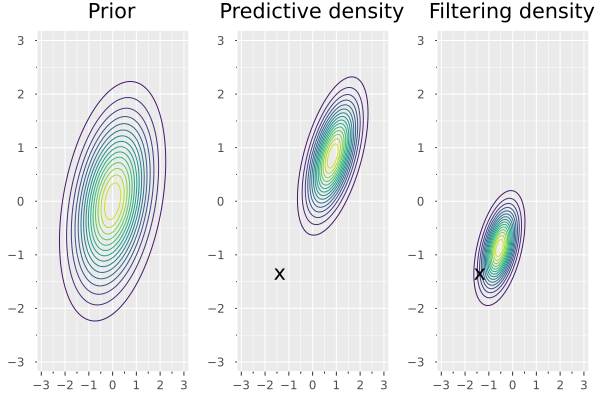

In [7]:
using Distributions
using LinearAlgebra
using Plots
using StatsPlots
using StatsBase
theme(:ggplot2)

#set paramaters of the model
A = [0.5 0.4;0.6 0.3]
B = I + zeros(2, 2)
P = [0.9 0.3;0.3 0.9]
Σ = 0.3.*P
R = 0.5.*P
T = 100
x0 = rand(MvNormal(P))

#simulate from LGmodel
x,y = Lgauss2(A,B,Σ,R,T,x0)

# run KF
Q0 = P
m0 = x0
fm,fQ,pm,pQ = KFfilter2(A,B,Σ,R,y,Q0,m0)

#calculate prior, filtering density and predictive density at time t,t-1
x_grid = range(-3.0, 3.0, length = 100)
y_grid = range(-3.0, 3.0, length = 100)
priordist = MvNormal(P)
filterdist = MvNormal(fm[100],fQ[100])
predictiondist = MvNormal(pm[99],pQ[99])
z1 = [pdf(priordist, [i,j]) for i in y_grid, j in x_grid]
z2 = [pdf(predictiondist, [i,j]) for i in y_grid, j in x_grid]
z3 = [pdf(filterdist, [i,j]) for i in y_grid, j in x_grid]
a=contour(x_grid,y_grid, z1,fill = false,color = :viridis, cbar = false,title="Prior")
contour(x_grid,y_grid, z2,fill = false,color = :viridis, cbar = false,title="Predictive density")
b=annotate!(x[1,100], x[2,100], "x", color = :black)
contour(x_grid,y_grid, z3,fill = false,color = :viridis, cbar = false,title="Filtering density")
c=annotate!(x[1,100], x[2,100], "x", color = :black)

plot(a,b,c,layout=(1,3))
#savefig("kalman.png")

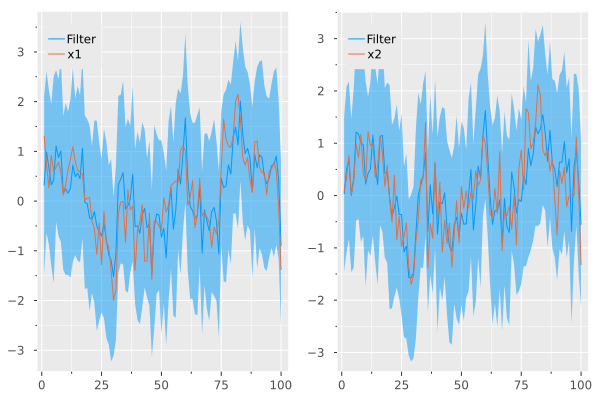


signal (15): Terminated: 15
in expression starting at /Users/yukihiro-su/.julia/packages/IJulia/e8kqU/src/kernel.jl:53


In [8]:
#estimation
est_state1 = zeros(100,100)
est_state2 = zeros(100,100)
CIest1 = zeros(100)
CIest2 = zeros(100)

for i in 1:100
    est = rand(MvNormal(fm[i],Symmetric(fQ[i])),100)
    est_state1[i,:] = est[1,:]
    est_state2[i,:] = est[2,:]
    CIest1[i] =  percentile(est_state1[i,:],97.5) -  percentile(est_state1[i,:],2.5)
    CIest2[i] =  percentile(est_state2[i,:],97.5) -  percentile(est_state2[i,:],2.5)
end

est1 = mean(est_state1, dims=2)
est2 = mean(est_state2, dims=2)

plot(est1,ribbon=CIest1,fillalpha=.5,label="Filter",foreground_color_legend = nothing,legend=:topleft)


a=plot!(x[1,:],label="x1")
plot(est2,ribbon=CIest2,fillalpha=.5,label="Filter",foreground_color_legend = nothing,legend=:topleft)
b=plot!(x[2,:],label="x2")


plot(a,b,layout=(1,2))
#savefig("kalman2.png")